In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185

In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

When scaling the MLP for large sequences, the number of parameters grows rapidly. Modern LLMs like GPT-4 can handle up to 128,000 tokens (each token is typically 2-5 characters), indicating something is amiss. 

Our core issue is that the number of parameters depends on the input sequence length. To address this, we can design an very simple architecture, which maintains a hidden state and updates it with linear layers. By reusing the same layers repeatedly, we can scale the sequence length indefinitely. 

This approach processes embeddings with the same parameters for all time steps, avoiding the need for unique parameters at each step. (the positionality is learned by the model and progressively encoded in the hidden state)

In [4]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fcxh = nn.Linear(emb_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, hidden_size) 
        self.fchh = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs) # removed flatten, shape is (batch_size, sequence_length, emb_size)
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) # (batch_size, hidden_size)
        
        for elm in range(emb.shape[1]):
            state = torch.tanh(self.fcxh(emb[:, elm]) + self.fchh(state))

        return self.fcxy(state)                

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RNN(emb_size=32, hidden_size=64).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

Millions of parameters: 0.01
Epoch ___0 - Loss: 4.279


../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [13,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


By calculating the loss at each time step, you're effectively turning a single sequence prediction into multiple label predictions, increasing the training signal. For the same computation, this gives you 20x the number of labels and updates, allowing the model to learn richer dependencies. This makes RNNs more efficient at handling long sequences by leveraging every step for learning.

In [5]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 150

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:] 
# going from predicting the last character to predicting the next character at every step
# Note the difference between sequences[2000:, 1:] and sequences[2000:, -1] in the previous cell
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]

Millions of parameters: 0.09
Epoch ___0 - Loss: 4.236
Epoch _300 - Loss: 2.299
Epoch _600 - Loss: 1.985
Epoch _900 - Loss: 1.887
Epoch 1200 - Loss: 1.776
Epoch 1500 - Loss: 1.680
Epoch 1800 - Loss: 1.628
Epoch 2100 - Loss: 1.595
Epoch 2400 - Loss: 1.567
Epoch 2700 - Loss: 1.550


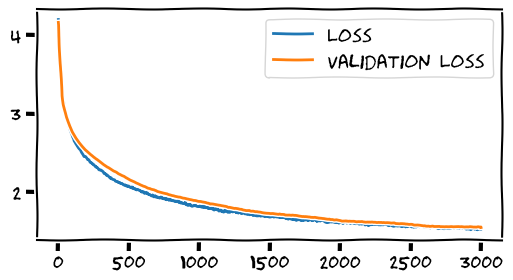

: 

In [6]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fcxh = nn.Linear(emb_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, vocab_size) 
        self.fchh = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs) # removed flatten, shape is (batch_size, sequence_length, emb_size)
        state = torch.zeros(inputs.shape[0], self.fchh.weight.shape[0]).to(device) # (batch_size, hidden_size)
        
        out = []
        for elm in range(emb.shape[1]):
            state = torch.tanh(self.fcxh(emb[:, elm]) + self.fchh(state))
            out.append(self.fcxy(state))
            
        return torch.stack(out[:], dim=1) # (batch_size, sequence_length, hidden_size) 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RNN(emb_size=32, hidden_size=64).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
        vlossi.append(vloss.item())

from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

In [ ]:
sequence_lengths = [1, 5, 10, 20, 50, 150, 400]
losses = []
vlosses = []

for sequence_length in sequence_lengths:
    texttoint = {elm: n for n, elm in enumerate(set(load))}
    inttotext = {n:elm for n, elm in enumerate(set(load))}
    dataset = [texttoint[c] for c in load]

    vocab_size = len(texttoint)

    sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
    inputs = sequences[2000:, :-1]
    labels = sequences[2000:, 1:] 
    # going from predicting the last character to predicting the next character at every step
    # Note the difference between sequences[2000:, 1:] and sequences[2000:, -1] in the previous cell
    val_inputs = sequences[:2000, :-1]
    val_labels = sequences[:2000, 1:]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = RNN(emb_size=32, hidden_size=256).to(device)

    epochs = 3000
    batch_size = 128
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

    lossi = []
    vlossi = []

    for epoch in range(epochs):
        indexes = torch.randint(0, len(inputs), (batch_size,))
        
        pred = model(inputs[indexes].to(device)) 
        loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lossi.append(loss.item())
        
        with torch.no_grad():
            pred = model(val_inputs.to(device))
            vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
            vlossi.append(vloss.item())

    print(f"Processed sequence length: {sequence_length:_>3d}, loss: {sum(lossi[-100:])/100:.3f}, validation loss: {sum(vlossi[-100:])/100:.3f}")
    losses.append(lossi)
    vlosses.append(vlossi)


Processed sequence length: __1, loss: 2.507, validation loss: 2.562
Processed sequence length: __5, loss: 2.060, validation loss: 2.127
Processed sequence length: _10, loss: 1.884, validation loss: 1.931
Processed sequence length: _20, loss: 1.758, validation loss: 1.778
Processed sequence length: _50, loss: 1.629, validation loss: 1.652
Processed sequence length: 150, loss: 1.540, validation loss: 1.577


We get severly limited return on out increase of sequence length. So we can try to optimize our architecture to make it better

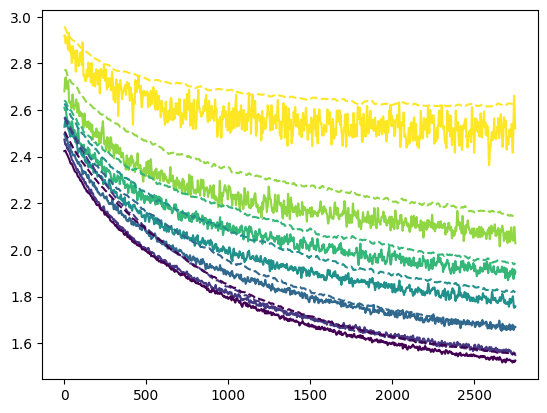

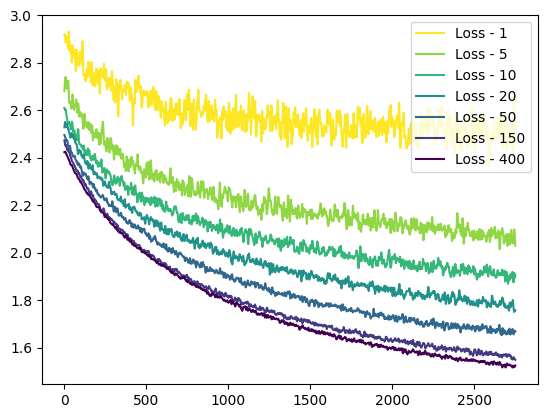

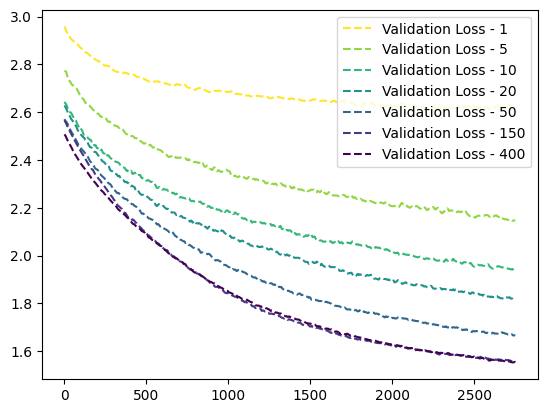

In [45]:
import numpy as np
colors = plt.cm.viridis(np.linspace(1, 0, len(sequence_lengths)))


for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(loss[250:], sigma=2), label=f"Loss - {sequence_length}", color=color)

plt.title("RNN Loss for different sequence lengths")
plt.legend()
plt.show()

for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(vloss[250:], sigma=2), label=f"Validation Loss - {sequence_length}", linestyle='--', color=color)

plt.title("RNN Validation Loss for different sequence lengths")
plt.legend()
plt.show()

for loss, vloss, sequence_length, color in zip(losses, vlosses, sequence_lengths, colors):
    plt.plot(gaussian_filter1d(loss[250:], sigma=2), label=f"Loss - {sequence_length}", color=color)
    plt.plot(gaussian_filter1d(vloss[250:], sigma=2), label=f"Validation Loss - {sequence_length}", linestyle='--', color=color)

plt.title("Comparison of Loss and Validation Loss\nat different sequence lengths")
plt.show()


The key difference between an RNN and an LSTM lies in their handling of the hidden state. An RNN updates the hidden state using a simple activation function, which can struggle with long-term dependencies due to vanishing gradients. In contrast, an LSTM introduces a more complex cell state and gates (input, forget, and output), allowing it to better retain and regulate information over long sequences, improving its ability to capture long-term dependencies.

Millions of parameters: 0.32
Epoch ___0 - Loss: 4.173
Epoch _300 - Loss: 2.399
Epoch _600 - Loss: 2.133
Epoch _900 - Loss: 1.993
Epoch 1200 - Loss: 1.867
Epoch 1500 - Loss: 1.810
Epoch 1800 - Loss: 1.801
Epoch 2100 - Loss: 1.712
Epoch 2400 - Loss: 1.657
Epoch 2700 - Loss: 1.661


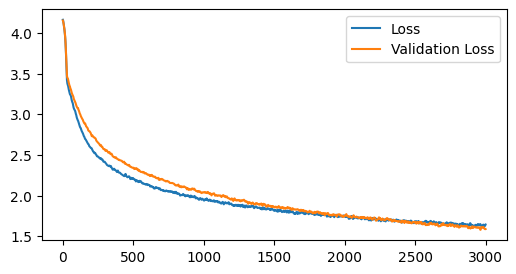

In [34]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)

sequence_length = 400
sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:] 
# going from predicting the last character to predicting the next character at every step
# Note the difference between sequences[2000:, 1:] and sequences[2000:, -1] in the previous cell
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]

class LSTM(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.ui = nn.Linear(emb_size, hidden_size)
        self.uf = nn.Linear(emb_size, hidden_size)
        self.uo = nn.Linear(emb_size, hidden_size)
        self.ug = nn.Linear(emb_size, hidden_size)
        self.wi = nn.Linear(hidden_size, hidden_size)
        self.wf = nn.Linear(hidden_size, hidden_size)
        self.wo = nn.Linear(hidden_size, hidden_size)
        self.wg = nn.Linear(hidden_size, hidden_size)
        self.fcxy = nn.Linear(hidden_size, vocab_size)  # Add output layer

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        state = torch.zeros(inputs.shape[0], self.wf.out_features).to(device)
        cell = torch.zeros(inputs.shape[0], self.wf.out_features).to(device)
        states = torch.zeros(inputs.shape[0], inputs.shape[1], self.wf.out_features).to(device)

        out = []
        for elm in range(emb.shape[1]):
            i = torch.sigmoid(self.ui(emb[:, elm]) + self.wi(state))
            f = torch.sigmoid(self.uf(emb[:, elm]) + self.wf(state))
            o = torch.sigmoid(self.uo(emb[:, elm]) + self.wo(state))
            g = torch.tanh(self.ug(emb[:, elm]) + self.wg(state))
            cell = f * cell + i * g
            state = o * torch.tanh(cell)
            states[:, elm] = state
            out.append(self.fcxy(state))

        return torch.stack(out[:], dim=1)
        
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTM(emb_size=32, hidden_size=64).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].view(-1).to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs)//4, (batch_size,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred.view(-1, 65), val_labels[indexes].view(-1).to(device))
        vlossi.append(vloss.item())

from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(6, 3))  
plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
plt.legend()

# Sequential is slow
RNNs and LSTMs are inharently sequential in nature, they process one input token at a time. 
CPUs have compute units extremely optimized to run sequential calculations as fast as possible, but there is a limit dictated by physics, and to get around it we usually build many compute units that can work in parallel. 

Note: to go fast, CPUs try to find parallelism in supposedly sequential instructions and try to run them at the same time to maximise performance (see branch prediction/speculative execution). This workload instead is inharently sequential in nature so even CPUs are inadequate. 

GPUs have thousands of processors working in parallel connected to lots of memory at very high bandwidth. This is why we often prefer to do more calculations in parallel than less in series, it's just faster because of the nature of the hardware. 
In particular, Linear layers with big batch sizes are very fast. 